In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    log_loss,
    roc_curve,
    auc,
)
from sklearn.preprocessing import LabelBinarizer
import xgboost as xgb

In [2]:
# Define the base directory for saving results
base_dir = "K_FOLD/XGBoost/"
os.makedirs(base_dir, exist_ok=True)  # Create the directory if it doesn't exist

In [3]:
# Load dataset
df = pd.read_csv("features.csv")  # Replace with your actual file

In [4]:
# Separate features and labels
X = df.iloc[:, 2:].values  # Feature vectors
y = df.iloc[:, 1].values   # Labels (man/woman)

In [5]:
# Encode labels to binary (0 and 1)
label_encoder = LabelBinarizer()
y = label_encoder.fit_transform(y).ravel()

In [6]:
# Initialize lists to store metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
train_losses = []
test_losses = []
fprs = []
tprs = []
auc_scores = []

In [7]:
# Plotting setup
plt.figure(figsize=(18, 6))

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

In [8]:
# Initialize KFold for 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
def create_model():
    """Creates and returns an XGBoost classifier with specified parameters."""
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        learning_rate=0.1,
        max_depth=5,
        n_estimators=100,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric=['logloss', 'error']  # Evaluation metrics
    )
    return model

Training Fold 1...


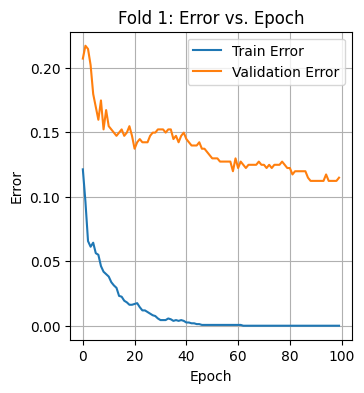

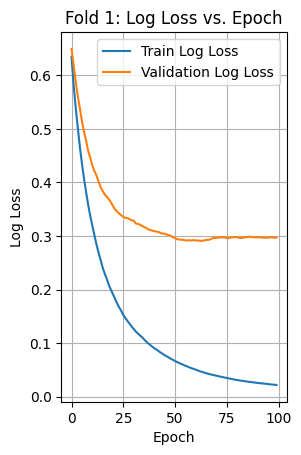

Fold 1 Results:
Test Accuracy: 0.89
Precision: 0.8696
Recall: 0.9045
F1-Score: 0.8867
Training Loss: 0.0221
Test Loss: 0.2971
AUC: 0.9506
Classification Report:
              precision    recall  f1-score   support

         man       0.90      0.87      0.88       202
       women       0.87      0.90      0.89       199

    accuracy                           0.89       401
   macro avg       0.89      0.89      0.89       401
weighted avg       0.89      0.89      0.89       401

--------------------------------------------------
Training Fold 2...


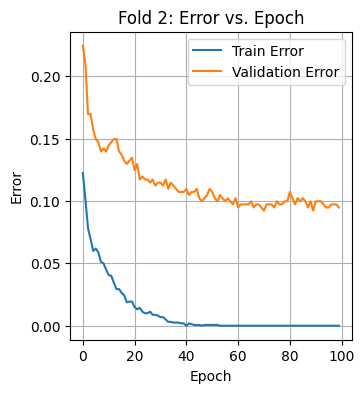

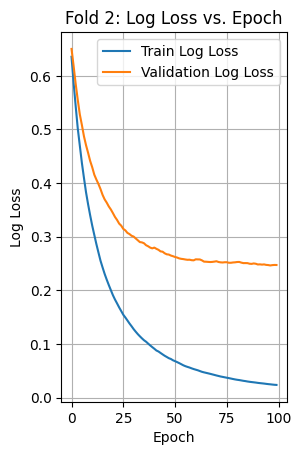

Fold 2 Results:
Test Accuracy: 0.91
Precision: 0.9119
Recall: 0.8934
F1-Score: 0.9026
Training Loss: 0.0235
Test Loss: 0.2471
AUC: 0.9621
Classification Report:
              precision    recall  f1-score   support

         man       0.90      0.92      0.91       204
       women       0.91      0.89      0.90       197

    accuracy                           0.91       401
   macro avg       0.91      0.91      0.91       401
weighted avg       0.91      0.91      0.91       401

--------------------------------------------------
Training Fold 3...


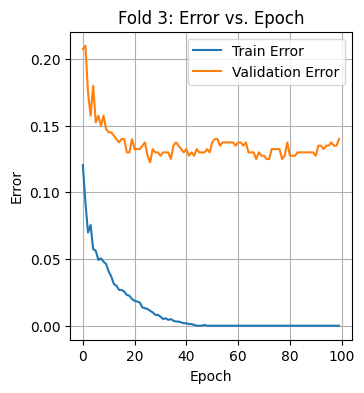

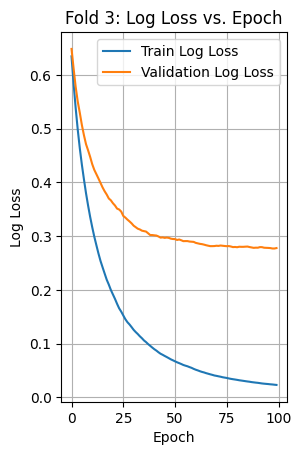

Fold 3 Results:
Test Accuracy: 0.86
Precision: 0.8674
Recall: 0.8307
F1-Score: 0.8486
Training Loss: 0.0231
Test Loss: 0.2779
AUC: 0.9550
Classification Report:
              precision    recall  f1-score   support

         man       0.85      0.89      0.87       211
       women       0.87      0.83      0.85       189

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400

--------------------------------------------------
Training Fold 4...


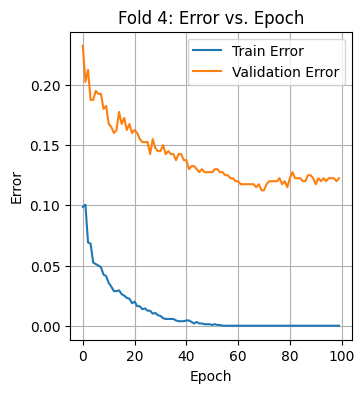

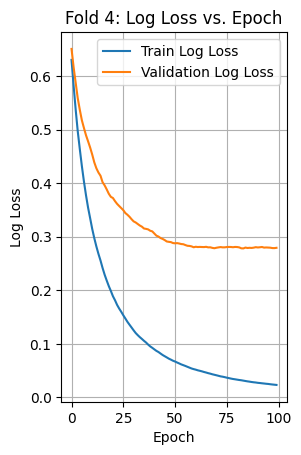

Fold 4 Results:
Test Accuracy: 0.88
Precision: 0.9022
Recall: 0.8426
F1-Score: 0.8714
Training Loss: 0.0232
Test Loss: 0.2793
AUC: 0.9560
Classification Report:
              precision    recall  f1-score   support

         man       0.86      0.91      0.88       203
       women       0.90      0.84      0.87       197

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400

--------------------------------------------------
Training Fold 5...


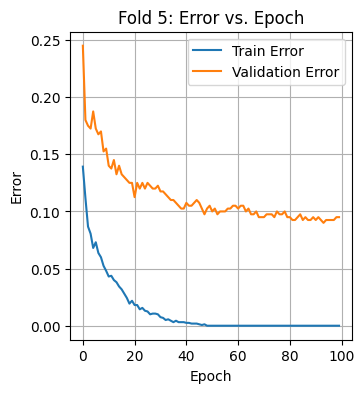

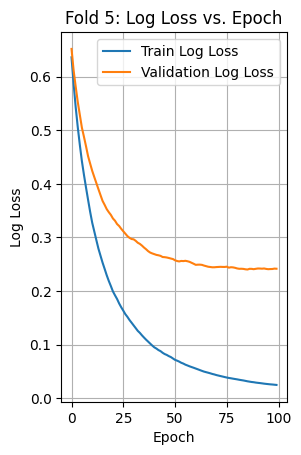

Fold 5 Results:
Test Accuracy: 0.91
Precision: 0.9372
Recall: 0.8858
F1-Score: 0.9108
Training Loss: 0.0249
Test Loss: 0.2416
AUC: 0.9645
Classification Report:
              precision    recall  f1-score   support

         man       0.87      0.93      0.90       181
       women       0.94      0.89      0.91       219

    accuracy                           0.91       400
   macro avg       0.90      0.91      0.90       400
weighted avg       0.91      0.91      0.91       400

--------------------------------------------------


In [11]:
# Perform 5-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    print(f"Training Fold {fold}...")
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create and train the XGBoost model
    model = create_model()
    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

    # Retrieve training history
    results = model.evals_result()
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)

    # Plot accuracy and loss vs. epoch for this fold
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(x_axis, results['validation_0']['error'], label='Train Error')
    plt.plot(x_axis, results['validation_1']['error'], label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(f'Fold {fold}: Error vs. Epoch')
    plt.legend()
    plt.grid()
    plt.show()

    plt.subplot(1, 2, 2)
    plt.plot(x_axis, results['validation_0']['logloss'], label='Train Log Loss')
    plt.plot(x_axis, results['validation_1']['logloss'], label='Validation Log Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss')
    plt.title(f'Fold {fold}: Log Loss vs. Epoch')
    plt.legend()
    plt.grid()
    plt.show()

    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, f"fold_{fold}_error_loss.png"))
    plt.close()

    # Predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Calculate training and test log losses
    train_loss = log_loss(y_train, model.predict_proba(X_train)[:, 1])
    test_loss = log_loss(y_test, y_pred_proba)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    auc_scores.append(roc_auc)

    # Print results for each fold
    print(f"Fold {fold} Results:")
    print(f"Test Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("-" * 50)

    # Save classification report for this fold to a text file
    with open(os.path.join(base_dir, f"fold_{fold}_classification_report.txt"), "w") as f:
        f.write(f"Fold {fold} Results:\n")
        f.write(f"Test Accuracy: {accuracy:.2f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1-Score: {f1:.4f}\n")
        f.write(f"Training Loss: {train_loss:.4f}\n")
        f.write(f"Test Loss: {test_loss:.4f}\n")
        f.write(f"AUC: {roc_auc:.4f}\n")
        f.write("Classification Report:\n")
        f.write(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
        f.write("-" * 50 + "\n")

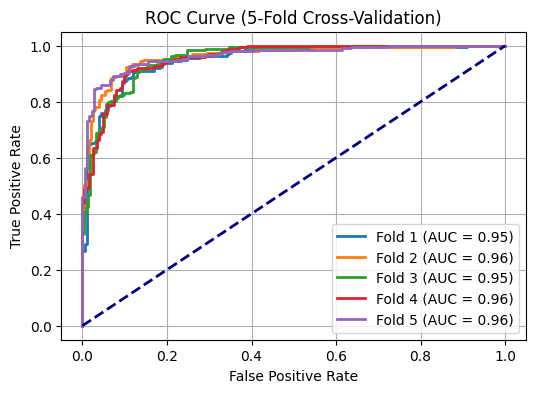

In [14]:
# Plot ROC Curve
plt.figure(figsize=(6, 4))
for i in range(5):
    plt.plot(fprs[i], tprs[i], lw=2, label=f"Fold {i+1} (AUC = {auc_scores[i]:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (5-Fold Cross-Validation)")
plt.legend(loc="lower right")
plt.grid()
plt.show()
plt.savefig(os.path.join(base_dir, "roc_curve.png"))
plt.close()

In [15]:
# Calculate average metrics across all folds
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)
avg_train_loss = np.mean(train_losses)
avg_test_loss = np.mean(test_losses)
avg_auc = np.mean(auc_scores)

In [16]:
# Save results to a text file
with open(os.path.join(base_dir, "K_FOLD_XGBoost_results.txt"), "w") as f:
    f.write("Average Results Across 5 Folds:\n")
    f.write(f"Average Test Accuracy: {avg_accuracy:.2f}\n")
    f.write(f"Average Precision: {avg_precision:.4f}\n")
    f.write(f"Average Recall: {avg_recall:.4f}\n")
    f.write(f"Average F1-Score: {avg_f1:.4f}\n")
    f.write(f"Average Training Loss: {avg_train_loss:.4f}\n")
    f.write(f"Average Test Loss: {avg_test_loss:.4f}\n")
    f.write(f"Average AUC: {avg_auc:.4f}\n")